# Transformada de Fourier Cuantica en Qiskit

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)   # anhadimos la puerta H
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n) # pasamos el numero, el qubit de control
                                            # y luego el objetivo.
    circuit.barrier(range(n))
    qft_rotations(circuit, n)

En esta funcion creamos el circuito con un n qubits, que va decrementado de 1 en 1 usando la recursiva.

In [3]:
def swap_registers(circuit, n):
    for qubit in range(n//2): # tenemos que hacer el swap para queden bien 
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

Para ver el funcionamiento del QFT, vamos a crear nuestro qubit de 4.

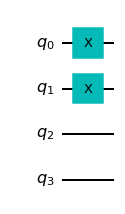

In [4]:
n = 4
qc = QuantumCircuit(n)

#Nuestro numero seria |1100> (12)
qc.x(0)
qc.x(1)

qc.draw('mpl')


Aplicamos la tranformada de fourier a nuestro qubit

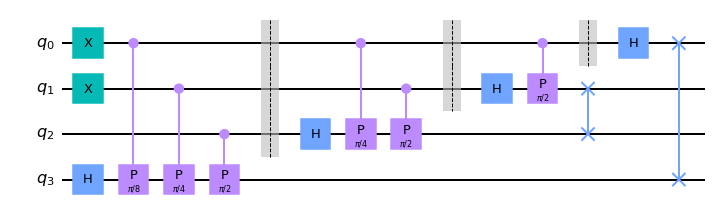

In [5]:
qft(qc,n)
qc.draw('mpl')

Usamaos el statevector simulator para simular el comportamiento

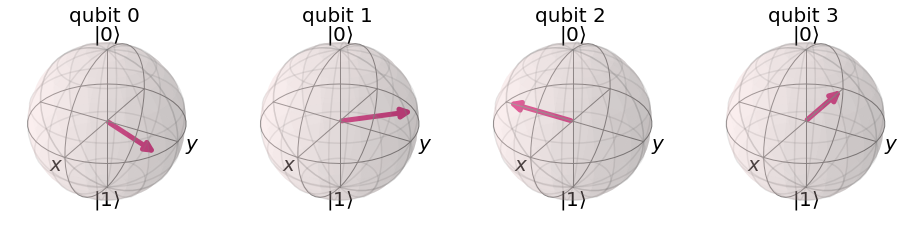

In [6]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Como podemos ver, los resultados son los esperados, ya que el Qubit 0  recorre 3/16, el qubit 1, el doble q es 6/16 (3/8), el qubit2 3/4 y el ultimo, 3/2( que da una vuelta media).

# Ejecucion en Backend reales

Para pode usar el backend real, tenemos que hacer la inversa de nuestro QFT, ya que los qubits estan en superposicion.

La transformada inversa se sacaría de la misma manera. Tan solo habría que ver que puertas van anulando las de la tranformada normal. Por lo tanto empezaríamos con los swap y luego con rotaciones del mismo ángulo en sentido opuesto.

In [7]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

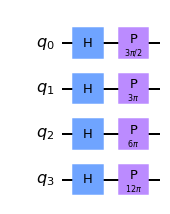

In [8]:
nqubits = 4
number = 12
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
    
qc.p(number*pi/8,0)
qc.p(number*pi/4,1)
qc.p(number*pi/2,2)
qc.p(number*pi/1,3)

qc.draw('mpl')

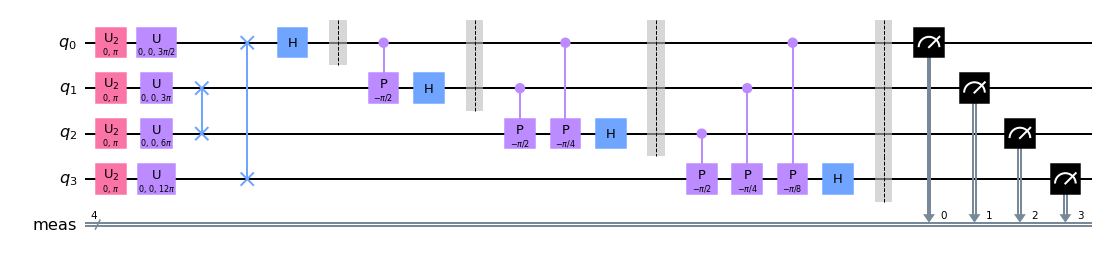

In [9]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

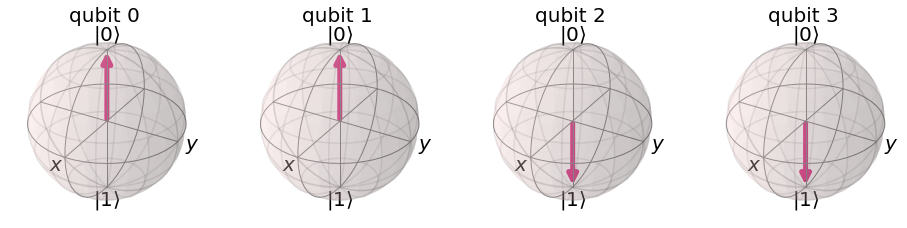

In [10]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [11]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_quito


In [12]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

Job Status: job has successfully run


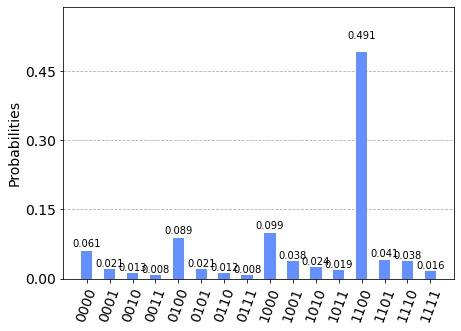

In [13]:
counts = job.result().get_counts()
plot_histogram(counts)

Como vemos, nuestro numero tiene un mayor porcentaje, que es el 1100